<a href="https://colab.research.google.com/github/ericbonelli/Cientista-de-Dados_EBAC/blob/main/Profissa%CC%83o_Cientista_de_Dados_M29_Pratique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarefa

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?"

Nosso objetivo é tentar agrupar os clientes conforme seu comportamento de navegação entre páginas administrativas, informativas e de produtos.

As variáveis estão descritas abaixo (em tradução livre do link indicado).

Por este motivo, o escopo desta análise estará fechado nas primeiras seis variáveis da tabela, referentes a quantidade e tempo de acesso por tipo de página, atributos que falam mais do comportamento de navegação do cliente que de características da página o da época do ano.

|Variavel                |Descrição          |
|------------------------|:-------------------|
|Administrative          | Quantidade de acessos em páginas administrativas|
|Administrative_Duration | Tempo de acesso em páginas administrativas |
|Informational           | Quantidade de acessos em páginas informativas  |
|Informational_Duration  | Tempo de acesso em páginas informativas  |
|ProductRelated          | Quantidade de acessos em páginas de produtos |
|ProductRelated_Duration | Tempo de acesso em páginas de produtos |
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  |
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações |
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico |
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) |
|Month                   | Mês  |
|OperatingSystems        | Sistema operacional do visitante |
|Browser                 | Browser do visitante |
|Region                  | Região |
|TrafficType             | Tipo de tráfego                  |
|VisitorType             | Tipo de visitante: novo ou recorrente |
|Weekend                 | Indica final de semana |
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [17]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
!pip install tqdm
from tqdm import tqdm

In [7]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Especialização em IA/Cientista de Dados - Ebac/Agrupamento e Segmentação de Dados/K-means/Profissão Cientista de Dados M29 - online_shoppers_intention.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [9]:
df.Revenue.value_counts(dropna=False)

,count
Revenue,
False,10422
True,1908


## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [11]:
print("\nValores missing por coluna:\n")
print(df.isnull().sum())


Valores missing por coluna:

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


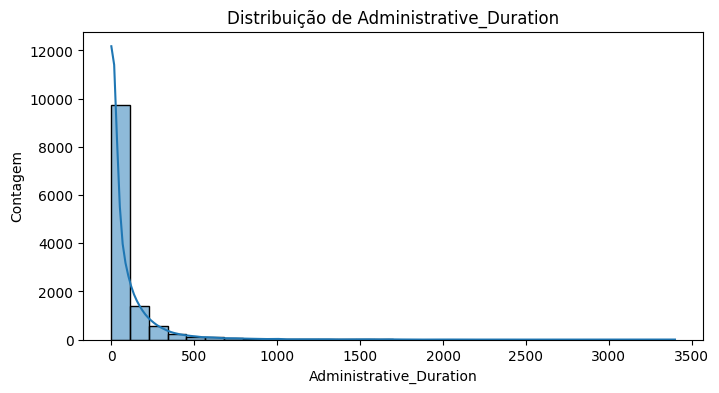

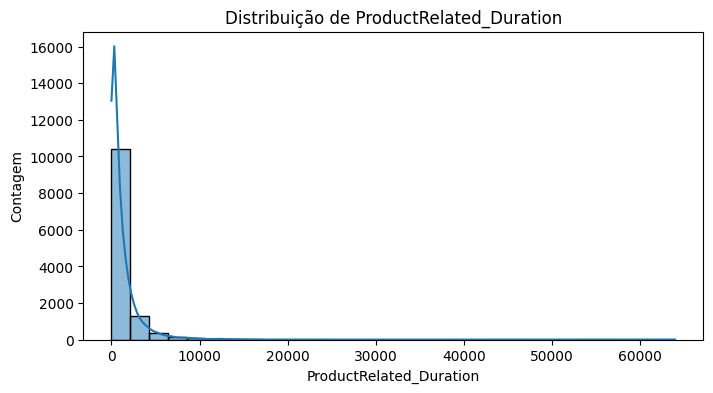

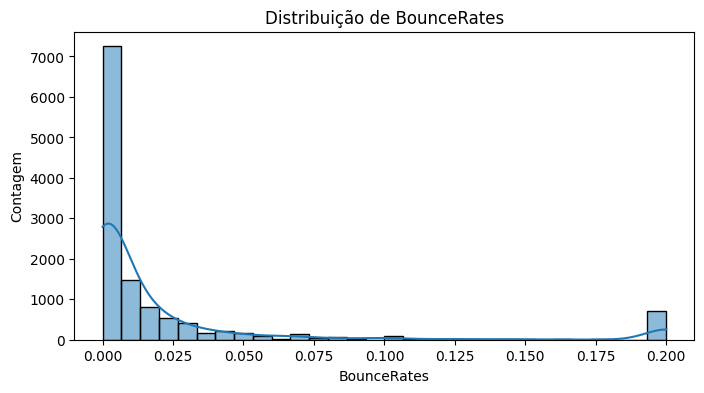

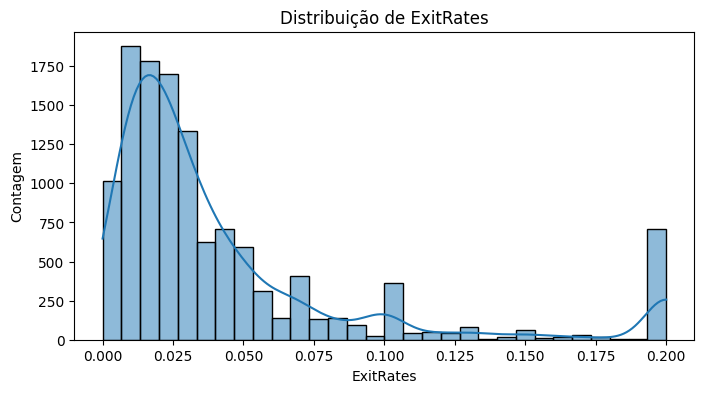

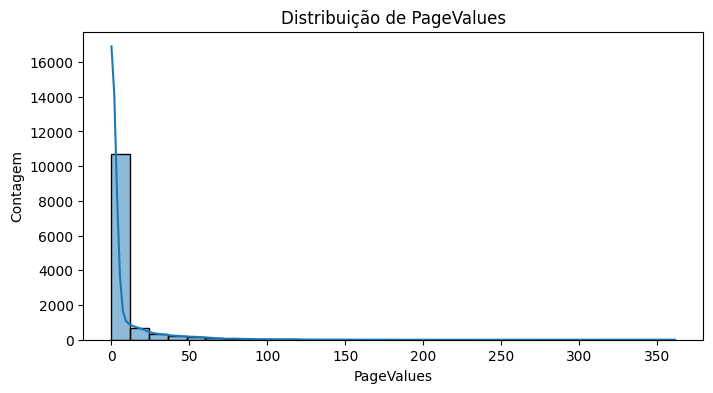

In [12]:
# Distribuição de algumas variáveis numéricas
variaveis_numericas = ['Administrative_Duration', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']

for var in variaveis_numericas:
    plt.figure(figsize=(8,4))
    sns.histplot(df[var], bins=30, kde=True)
    plt.title(f'Distribuição de {var}')
    plt.xlabel(var)
    plt.ylabel('Contagem')
    plt.show()

In [13]:
# Tratamentos sugeridos
# 7.1. Transformar Month para ordem numérica
mes_map = {
    'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'June':6,
    'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12
}
df['Month_num'] = df['Month'].map(mes_map)

# 7.2. Transformar VisitorType em binário
df['VisitorType_binary'] = df['VisitorType'].apply(lambda x: 1 if x == 'Returning_Visitor' else 0)

# 7.3. Aplicar transformação log (log1p) nas variáveis de duração
duracao_vars = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration']
for var in duracao_vars:
    df[f'{var}_log'] = np.log1p(df[var])

## Número de grupos

Utilize as técnicas vistas em aula que te ajudem a decidir pelo número de grupos a ser utilizados.

In [22]:
# Selecionar variáveis para o clustering


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


variaveis_cluster = [
    'Administrative', 'Administrative_Duration_log',
    'Informational', 'Informational_Duration_log',
    'ProductRelated', 'ProductRelated_Duration_log',
    'BounceRates', 'ExitRates', 'PageValues'
]

X = df[variaveis_cluster]

In [23]:
# Padronizar os dados

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

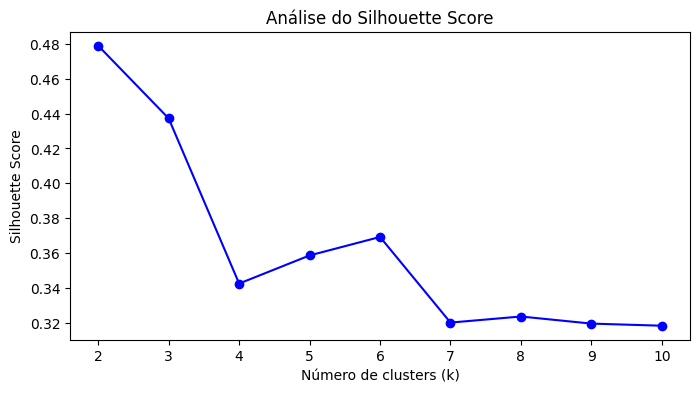

In [24]:
# Método da Silhueta

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, labels)
    silhouette_scores.append(silhouette)

# Plotando o gráfico da Silhueta
plt.figure(figsize=(8,4))
plt.plot(range(2, 11), silhouette_scores, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Análise do Silhouette Score')
plt.show()

## Avaliação dos grupos

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final.
- Se puder, sugira nomes para os grupos.

In [31]:
# Rodar KMeans para k=2 e k=3

# K = 2
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
df['Cluster_2'] = kmeans_2.fit_predict(X_scaled)

# K = 3
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster_3'] = kmeans_3.fit_predict(X_scaled)

In [35]:
# Avaliar BounceRates
bounce_k2 = df.groupby('Cluster_2')['BounceRates'].mean()
bounce_k3 = df.groupby('Cluster_3')['BounceRates'].mean()

# Avaliar Revenue (proporção de compradores)
revenue_k2 = df.groupby('Cluster_2')['Revenue'].mean()
revenue_k3 = df.groupby('Cluster_3')['Revenue'].mean()

# Mostrar
print("Média BounceRates (k=2):\n", bounce_k2)
print("Proporção Revenue (k=2):\n", revenue_k2)

print("Média BounceRates (k=3):\n", bounce_k3)
print("Proporção Revenue (k=3):\n", revenue_k3)

Média BounceRates (k=2):
 Cluster_2
0    0.008982
1    0.168663
Name: BounceRates, dtype: float64
Proporção Revenue (k=2):
 Cluster_2
0    0.168170
1    0.005882
Name: Revenue, dtype: float64
Média BounceRates (k=3):
 Cluster_3
0    0.010064
1    0.006917
2    0.175448
Name: BounceRates, dtype: float64
Proporção Revenue (k=3):
 Cluster_3
0    0.146002
1    0.253884
2    0.003168
Name: Revenue, dtype: float64


| Cluster | Perfil | Nome sugerido |
|:---|:---|:---|
| 0 | Bons clientes, mas não tanto quanto Cluster 1 | **Compradores Comuns** |
| 1 | Clientes excelentes, super engajados e alta compra | **Compradores Premium** |
| 2 | Visitantes que quase não compram e abandonam rápido | **Exploradores Casuais** |


## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*).
- Qual grupo possui clientes mais propensos à compra?

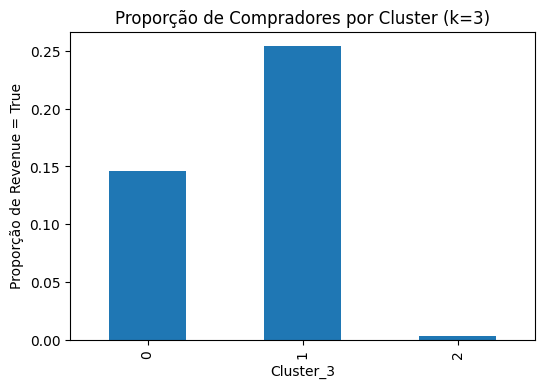

In [36]:
# Visualizar Revenue por Cluster (barras)

# Revenue - K=3
revenue_cluster3 = df.groupby('Cluster_3')['Revenue'].mean()

plt.figure(figsize=(6,4))
revenue_cluster3.plot(kind='bar')
plt.title('Proporção de Compradores por Cluster (k=3)')
plt.ylabel('Proporção de Revenue = True')
plt.show()

Para k=3

Cluster 1 (Compradores Premium): Bounce ainda mais baixo (0,69%), 25,4% dos clientes compram

Cluster 0 (Compradores Comuns): Bounce baixo (1,00%), 14,6% compram (ok, mas pior que Cluster 1).

Cluster 2 (Exploradores Casuais): Bounce muito alto (17,5%), só 0,3% compram → público ruim.

✅ Cluster 1 é mais propenso a comprar!